In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

# 獲取數據
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')

# 提取收盤價
data = data[['Close']]

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_61711/118444856.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')
[*********************100%***********************]  1 of 1 completed


/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-

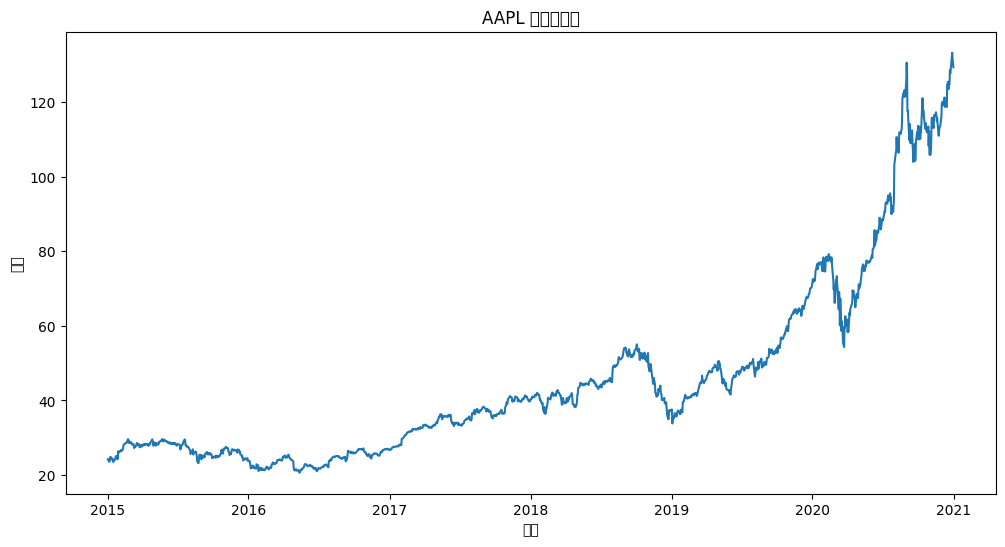

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title('AAPL 股票收盤價')
plt.xlabel('日期')
plt.ylabel('價格')
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

In [5]:
def create_dataset(dataset, lookback=60):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        X.append(dataset[i:(i+lookback), 0])
        y.append(dataset[i+lookback, 0])
    return np.array(X), np.array(y)

# 轉換為numpy數組
dataset = data.values

# 定義lookback窗口大小
lookback = 60

X, y = create_dataset(dataset, lookback)

In [6]:
# 劃分比例
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [7]:
# 調整輸入形狀
X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

In [11]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用設備：{device}')

使用設備：cpu


In [16]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(StockPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 定義LSTM層
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 定義全連接層
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # 初始化隱藏狀態和細胞狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # 前向傳播LSTM
        out, _ = self.lstm(x, (h0, c0))
        # 取最後一個時間步的輸出
        out = self.fc(out[:, -1, :])
        return out

In [19]:
model = StockPriceLSTM().to(device)

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

In [22]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        # 在測試集上評估
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
        print(f'Epoch [{epoch+1}/{num_epochs}], 訓練集Loss: {loss.item():.4f}, 測試集Loss: {test_loss.item():.4f}')

Epoch [10/100], 訓練集Loss: 0.0089, 測試集Loss: 0.2126
Epoch [20/100], 訓練集Loss: 0.0075, 測試集Loss: 0.2554
Epoch [30/100], 訓練集Loss: 0.0074, 測試集Loss: 0.2455
Epoch [40/100], 訓練集Loss: 0.0068, 測試集Loss: 0.1980
Epoch [50/100], 訓練集Loss: 0.0054, 測試集Loss: 0.1522
Epoch [60/100], 訓練集Loss: 0.0011, 測試集Loss: 0.0856
Epoch [70/100], 訓練集Loss: 0.0007, 測試集Loss: 0.0218
Epoch [80/100], 訓練集Loss: 0.0005, 測試集Loss: 0.0136
Epoch [90/100], 訓練集Loss: 0.0003, 測試集Loss: 0.0405
Epoch [100/100], 訓練集Loss: 0.0002, 測試集Loss: 0.0089


In [23]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反歸一化
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-

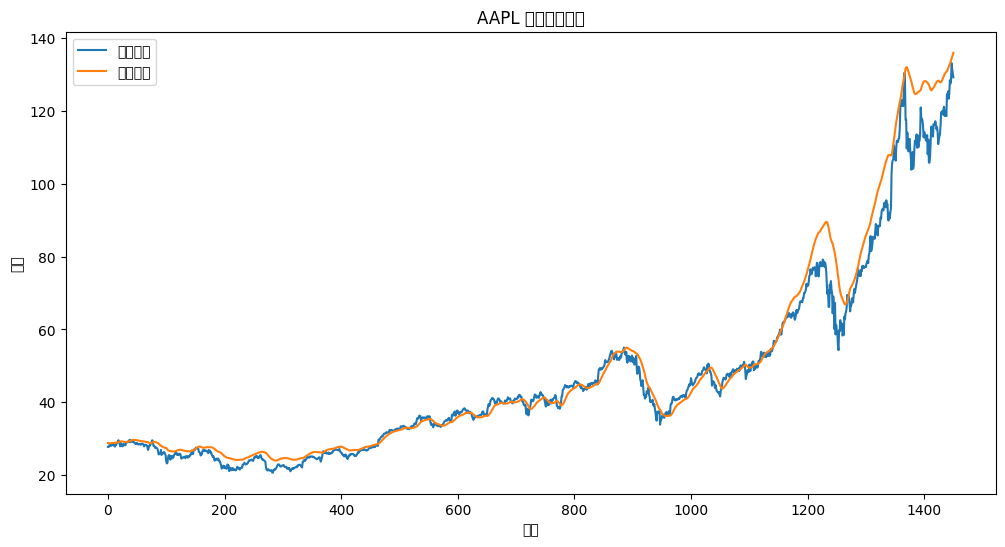

In [24]:
# 構建完整的時間序列
predicted = np.concatenate((train_predict, test_predict), axis=0)
actual = scaler.inverse_transform(dataset[lookback:])

plt.figure(figsize=(12,6))
plt.plot(actual, label='實際價格')
plt.plot(predicted, label='預測價格')
plt.title('AAPL 股票價格預測')
plt.xlabel('時間')
plt.ylabel('價格')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error

train_score = mean_squared_error(y_train_actual, train_predict)
test_score = mean_squared_error(y_test_actual, test_predict)
print(f'訓練集MSE: {train_score:.2f}')
print(f'測試集MSE: {test_score:.2f}')

訓練集MSE: 3.06
測試集MSE: 112.45
